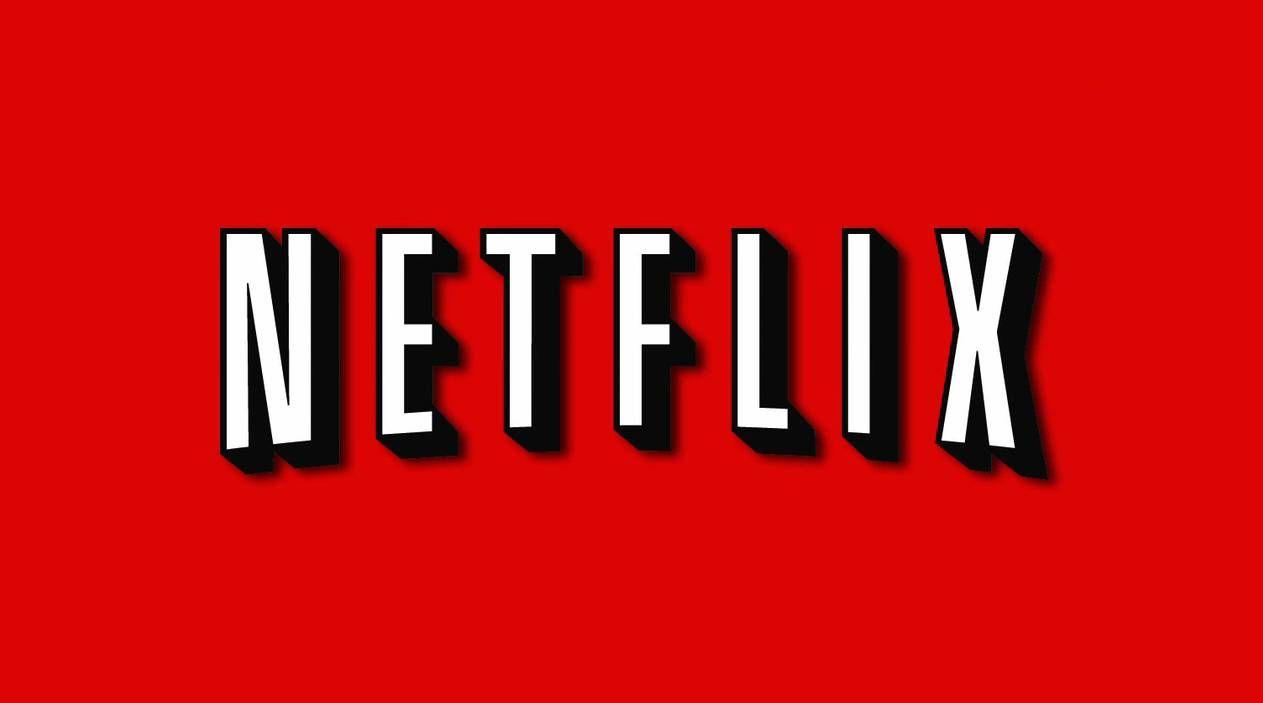

<h1 style="font-size:50px; font-family:Garamond; font-weight:normal; background-color:#f6f6f6; color:'black'; text-align:center; border-radius:100px 100px;">
1.Introduction
</h1>


<h2 style="font-size:25px; font-family:Garamond; font-weight:normal; background-color:#f6f6f6; color:'black'; text-align:center; border-radius:100px 100px;">
Netflix is a popular streaming service that offers a vast catalog of movies, TV shows, and original contents. This dataset is a cleaned version of the original version which can be found here. The data consist of contents added to Netflix from 2008 to 2021. The oldest content is as old as 1925 and the newest as 2021. This dataset will be cleaned with PostgreSQL and visualized with Tableau. The purpose of this dataset is to test my data cleaning and visualization skills. The cleaned data can be found below and the Tableau dashboard can be found here .
</h2>

In [1]:
!pip install pywaffle

In [2]:
import os
import pandas as pd
import tqdm as tqdm
from scipy import stats
import numpy as np
import string
import matplotlib.pyplot as plt
from PIL import Image
import missingno as msno
import seaborn as sns
import plotly.express as px
from pywaffle import Waffle
import plotly.graph_objs as go
from plotly.offline import iplot,plot,init_notebook_mode
import squarify
from collections import Counter
from wordcloud import WordCloud, STOPWORDS 
import warnings
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
             display: table-cell;
             text-align: center;
             vertical-align: middle;
}
""")

<h1 style = "font-size:50px; font-family:Garamond ; font-weight : normal; background-color: #f6f6f6 ; color : 'black'; text-align: center; border-radius: 100px 100px;"> 2. Netflix Data Loading and First Impression </h1>


In [4]:
df = pd.read_csv('netflix1.csv')

In [5]:
df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


In [6]:
df.shape

(8790, 10)

In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   country       8790 non-null   object
 5   date_added    8790 non-null   object
 6   release_year  8790 non-null   int64 
 7   rating        8790 non-null   object
 8   duration      8790 non-null   object
 9   listed_in     8790 non-null   object
dtypes: int64(1), object(9)
memory usage: 686.8+ KB


In [8]:
df.describe(include = [np.object]).T.style.set_properties(**{'background-color':'white',
                                     'color': 'black',
                                      'border-color':'black' })

,count,unique,top,freq
show_id,8790,8790,s1,1
type,8790,2,Movie,6126
title,8790,8787,9-Feb,2
director,8790,4528,Not Given,2588
country,8790,86,United States,3240
date_added,8790,1713,1/1/2020,110
rating,8790,14,TV-MA,3205
duration,8790,220,1 Season,1791
listed_in,8790,513,"Dramas, International Movies",362


In [9]:
df.nunique()

show_id         8790
type               2
title           8787
director        4528
country           86
date_added      1713
release_year      74
rating            14
duration         220
listed_in        513
dtype: int64

**`OBSERVATIONS:`**
- Key observations include that the show_id and title counts are nearly identical, indicating unique identifiers for most entries. 
- The type column has only two unique values, likely representing categories such as "Movie" and "TV Show." 
- The director and country columns show moderate diversity, suggesting varied production origins and creative contributors.
- date_added has fewer unique entries compared to release_year, indicating clustering of additions. 
- rating and duration show smaller unique counts, reflecting common classifications and length ranges, while listed_in has many unique categories, likely genre tags.

In [10]:
df.isna().sum()

show_id         0
type            0
title           0
director        0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64

In [11]:
df_orig = df.copy() # copying original dataset 

# handling missing values
df['director'] = df['director'].fillna('NoDataAvailable')
df['country'] = df['country'].fillna(df['country'].mode()[0])
df['date_added'] = df['date_added'].fillna(df['date_added'].mode()[0])
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])

<h1 style = "font-size:50px; font-family:Garamond ; font-weight : normal; background-color: #f6f6f6 ; color : 'black'; text-align: center; border-radius: 100px 100px;"> 3. Data Pre-processing and Feature Engineering</h1>

In [12]:
df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,9/25/2021,2020,PG-13,90 min,Documentaries
1,s3,TV Show,Ganglands,Julien Leclercq,France,9/24/2021,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act..."
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,9/24/2021,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries"
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,9/22/2021,2021,TV-PG,91 min,"Children & Family Movies, Comedies"
4,s8,Movie,Sankofa,Haile Gerima,United States,9/24/2021,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies"


### `Let's check for any inconsistencies in the dataset.`

In [13]:
df.country.value_counts()

United States     3240
India             1057
United Kingdom     638
Pakistan           421
Not Given          287
                  ... 
Iran                 1
West Germany         1
Greece               1
Zimbabwe             1
Soviet Union         1
Name: country, Length: 86, dtype: int64

- The absence of country data for 287 entries suggests incomplete metadata, which could skew insights 
- The good news is no data inconsistencies found.

In [14]:
df.rating.value_counts()

TV-MA       3205
TV-14       2157
TV-PG        861
R            799
PG-13        490
TV-Y7        333
TV-Y         306
PG           287
TV-G         220
NR            79
G             41
TV-Y7-FV       6
NC-17          3
UR             3
Name: rating, dtype: int64

### `Although ratings have predefined categories, they can be further grouped based on target audience..`

In [15]:
df['audience_category'] = 'Unknown'

df.loc[df['rating'].isin(['TV-MA', 'R', 'NC-17', 'UR']), 'audience_category'] = 'Adults'
df.loc[df['rating'].isin(['TV-14', 'PG-13']), 'audience_category'] = 'Teens'
df.loc[df['rating'].isin(['TV-PG', 'PG', 'TV-Y7', 'TV-Y7-FV', 'TV-Y', 'TV-G', 'G']), 'audience_category'] = 'Kids/Family'
df.loc[df['rating'] == 'NR', 'audience_category'] = 'Unrated'

### `Let’s examine the column data types and determine if any adjustments are needed...`

In [16]:
df.dtypes

show_id              object
type                 object
title                object
director             object
country              object
date_added           object
release_year          int64
rating               object
duration             object
listed_in            object
audience_category    object
dtype: object

### `date_added is an object which is suppose to be a datetime[64] data type. Changing it now..`

In [17]:
df['date_added'] = pd.to_datetime(df['date_added'])

In [18]:
df.dtypes

show_id                      object
type                         object
title                        object
director                     object
country                      object
date_added           datetime64[ns]
release_year                  int64
rating                       object
duration                     object
listed_in                    object
audience_category            object
dtype: object

### `We can extract month and year from date_added for furthet analysis..`

In [19]:
df['added_year'] = df['date_added'].dt.year
df['added_month'] = df['date_added'].dt.month_name()

In [20]:
df.head()

,show_id,type,title,director,country,date_added,release_year,rating,duration,listed_in,audience_category,added_year,added_month
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2021-09-25,2020,PG-13,90 min,Documentaries,Teens,2021,September
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",Adults,2021,September
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",Adults,2021,September
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021-09-22,2021,TV-PG,91 min,"Children & Family Movies, Comedies",Kids/Family,2021,September
4,s8,Movie,Sankofa,Haile Gerima,United States,2021-09-24,1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies",Adults,2021,September


In [21]:
df.drop(columns='date_added',inplace=True)

### `Looking at the contents of listed_in, its evident that its a genre and also it has more than one genre.`

### `What can be done??`

### `Some content is international, while others are not. The distinction can be extracted & analyzed later.`

In [22]:
df['listed_in'] = df['listed_in'].apply(lambda x: x.split(', '))

df['content_origin'] = df['listed_in'].apply(
    lambda genres: 'International' if any('International' in genre for genre in genres) else 'Domestic')

In [23]:
df['content_origin'].value_counts()/df.shape[0]*100

Domestic         53.34471
International    46.65529
Name: content_origin, dtype: float64

### `It can also be observed that some content is Multi Genre while others are Single Genre Content..`

In [24]:
df['genre_type'] = df['listed_in'].apply(lambda genres: 'Multi Genre' if len(genres) > 1 else 'Single Genre')

In [25]:
df.head()

,show_id,type,title,director,country,release_year,rating,duration,listed_in,audience_category,added_year,added_month,content_origin,genre_type
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,United States,2020,PG-13,90 min,[Documentaries],Teens,2021,September,Domestic,Single Genre
1,s3,TV Show,Ganglands,Julien Leclercq,France,2021,TV-MA,1 Season,"[Crime TV Shows, International TV Shows, TV Ac...",Adults,2021,September,International,Multi Genre
2,s6,TV Show,Midnight Mass,Mike Flanagan,United States,2021,TV-MA,1 Season,"[TV Dramas, TV Horror, TV Mysteries]",Adults,2021,September,Domestic,Multi Genre
3,s14,Movie,Confessions of an Invisible Girl,Bruno Garotti,Brazil,2021,TV-PG,91 min,"[Children & Family Movies, Comedies]",Kids/Family,2021,September,Domestic,Multi Genre
4,s8,Movie,Sankofa,Haile Gerima,United States,1993,TV-MA,125 min,"[Dramas, Independent Movies, International Mov...",Adults,2021,September,International,Multi Genre


In [26]:
print('Columns before pre-processing:',df_orig.shape[1])
print('Columns after pre-processing:',df.shape[1])

Columns before pre-processing: 10
Columns after pre-processing: 14


<Figure size 1500x600 with 0 Axes>

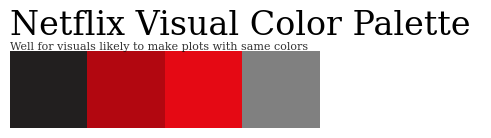

In [27]:
colors = ['#221f1f', '#b20710', '#e50914','grey']
plt.figure(figsize=(15,6))
sns.palplot(colors,size = 1)
plt.title("Netflix Visual Color Palette ",loc='left',fontfamily= 'Serif',fontsize=24,y=1.1)
plt.text(-.5,-0.51, 'Well for visuals likely to make plots with same colors',{'font':'serif', 'color':'black','weight':'normal','size':8}, alpha = 0.8 )
plt.axis('off')
plt.show()

###  <a id = 'section5'> </a>

<h2 style = "font-size:50px; font-family:Garamond ; font-weight : normal; background-color: #f6f6f6 ; color : 'black'; text-align: center; border-radius: 100px 100px;"> 4. Netflix Content Analysis</h2>

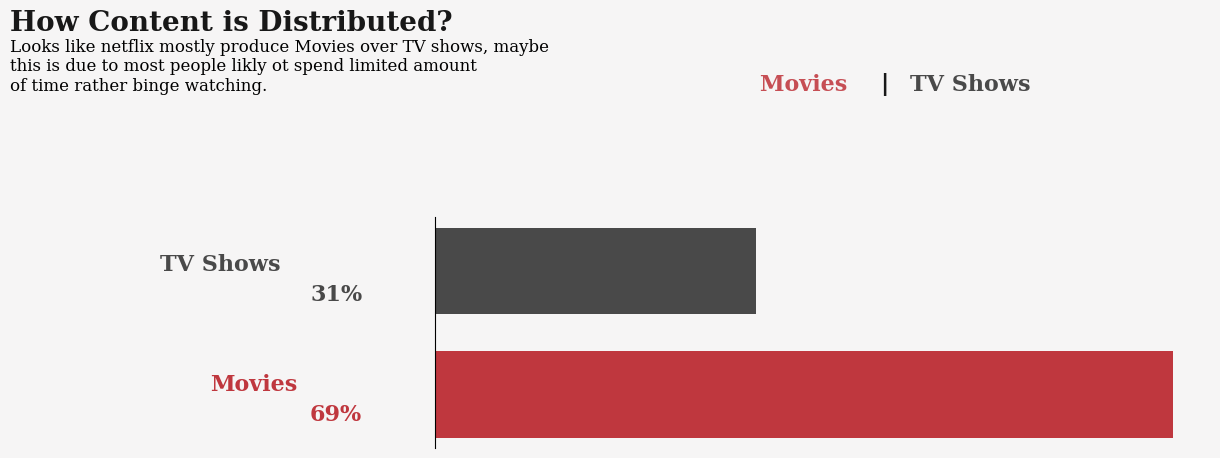

In [28]:
x = df['type'].value_counts()

# plot
fig, ax = plt.subplots(figsize = (10,3))
ax.barh([1], x.values[1], height = 0.7, color = 'black', alpha = 0.7)
fig.text(-0.15,0.7, 'TV Shows', {'font': 'Serif','weight':'bold','size': '16','style':'normal', 'color':'black'}, alpha = 0.7)
fig.text(0,0.6, '31%',{'font':'Serif', 'weight':'bold','size':'16','color':'black'}, alpha = 0.7)


ax.barh([0], x.values[0], height = 0.7, color = '#b20710', alpha = 0.8)
fig.text(-0.1,0.3, 'Movies',{'font': 'Serif','weight':'bold','size': '16','style':'normal', 'color':'#b20710'}, alpha = 0.8)
fig.text(0,0.2, '69%',{'font':'Serif','weight':'bold' ,'size':'16','color':'#b20710'}, alpha = 0.8)


fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

fig.text(-0.3,1.5, 'How Content is Distributed?' ,{'font': 'Serif', 'size': '20','weight':'bold', 'color':'black'}, alpha = 0.9)
fig.text(0.45,1.3, 'Movies ', {'font': 'Serif','weight':'bold','size': '16', 'color':'#b20710'}, alpha = 0.7)
fig.text(0.57, 1.3,'|', {'color':'black' , 'size':'16', 'weight': 'bold'}, alpha = 0.9)
fig.text(0.6, 1.3,'TV Shows', {'font': 'Serif','weight':'bold', 'size': '16','color':'black'}, alpha = 0.7)
fig.text(-0.3,1.3, 'Looks like netflix mostly produce Movies over TV shows, maybe \nthis is due to most people likly ot spend limited amount \nof time rather binge watching.', 
        {'font':'Serif', 'size':'12','color': 'black'})

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

<h2 style = "font-size:50px; font-family:Garamond ; font-weight : normal; background-color: #f6f6f6 ; color : 'black'; text-align: center; border-radius: 100px 100px;"> 5. Netflix Rating Analysis</h2>

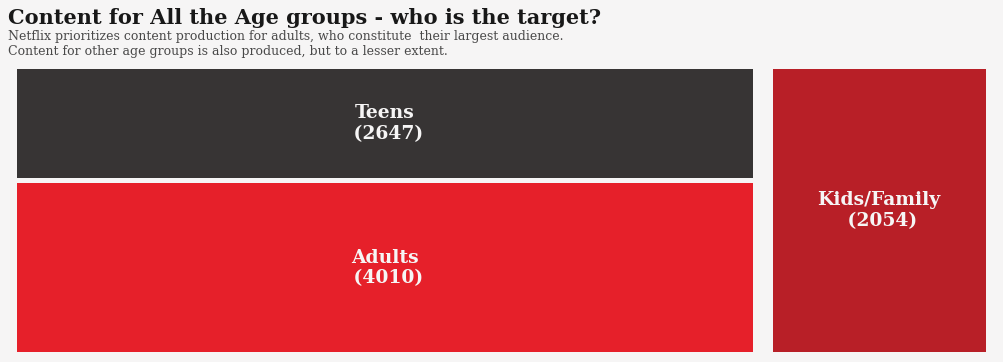

In [55]:
age_ratings = df['audience_category'].value_counts()[:3]

labels = [ str(idx) + "\n (" + str(val) + ")" for idx, val in age_ratings.items()]

fig, ax = plt.subplots(figsize = (17,5), dpi = 75)
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')


squarify.plot(sizes= age_ratings.values, label = labels,
              color = ['#e50914','#221f1f','#b20710'],
              ax = ax, text_kwargs = {'font':'serif', 'size':'18', 'color': '#f6f5f5', 'weight':'bold'},
              alpha = 0.9,pad=True)

ax.text(0,114.8, 'Content for All the Age groups - who is the target?',
        {'font':'serif', 'size':'20', 'color':'black','weight':'bold'}, alpha =0.9)
ax.text(0,104, "Netflix prioritizes content production for adults, who constitute  their largest audience. \nContent for other age groups is also produced, but to a lesser extent.",
        {'font':'serif', 'size':'12', 'color':'black','weight':'normal'},alpha = 0.7)

ax.axis('off')

fig.show()

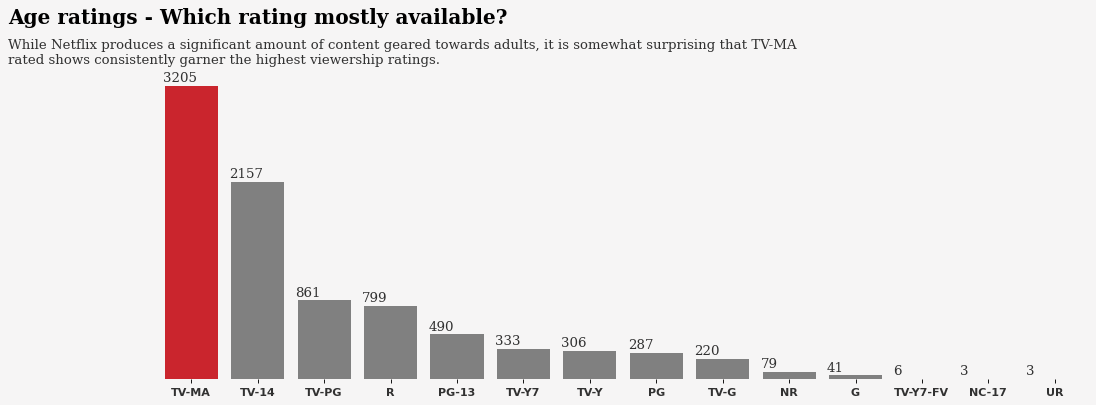

In [54]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=80)
ax.set_facecolor('#f6f5f5')
fig.patch.set_facecolor('#f6f5f5')
colors = ['#e50914', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']
sns.countplot(data=df, x='rating', palette=colors, order=df['rating'].value_counts().index, ax=ax)
a = df['rating'].value_counts()
label = a.values.tolist()
for i in range(len(label)):
    x = i - 0.43
    y = label[i] + 50 
    ax.text(x, y, '{}'.format(label[i]), {'font': 'serif', 'weight': 'normal', 'color': 'black', 'fontsize': 12}, alpha=0.8)
fig.text(0, 1, 'Age ratings - Which rating mostly available?', {'font': 'serif', 'color': 'black', 'fontsize': 18, 'weight': 'bold'}, alpha=1)
fig.text(0, 0.90, "While Netflix produces a significant amount of content geared towards adults, it is somewhat surprising that TV-MA \nrated shows consistently garner the highest viewership ratings.", {'font': 'serif', 'color': 'black', 'size': 12}, alpha=0.8)
ax.set_xlabel('')
ax.set_xticklabels(a.index, fontweight='bold', alpha=0.8)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


<h2 style = "font-size:50px; font-family:Garamond ; font-weight : normal; background-color: #f6f6f6 ; color : 'black'; text-align: center; border-radius: 100px 100px;"> 6. Netflix Content Analysis based on Time</h2>

In [31]:
add_year = df['added_year'].value_counts()
release = df['release_year'].value_counts()

tv_shows = df[df['type'] == 'TV Shows']
movies = df[df['type'] == 'Movies']

add_df = pd.DataFrame({'year': add_year.index, 'added_year': add_year.values})
release_df = pd.DataFrame({'year': release.index, 'release_year': release.values})

year_df = pd.merge(add_df, release_df, how = 'right', on = 'year')
year_df.fillna('0', inplace = True)
year_df['added_year'] = year_df.added_year.astype('int')

year_df = year_df.sort_values('year', ascending = False).reset_index(drop = True)

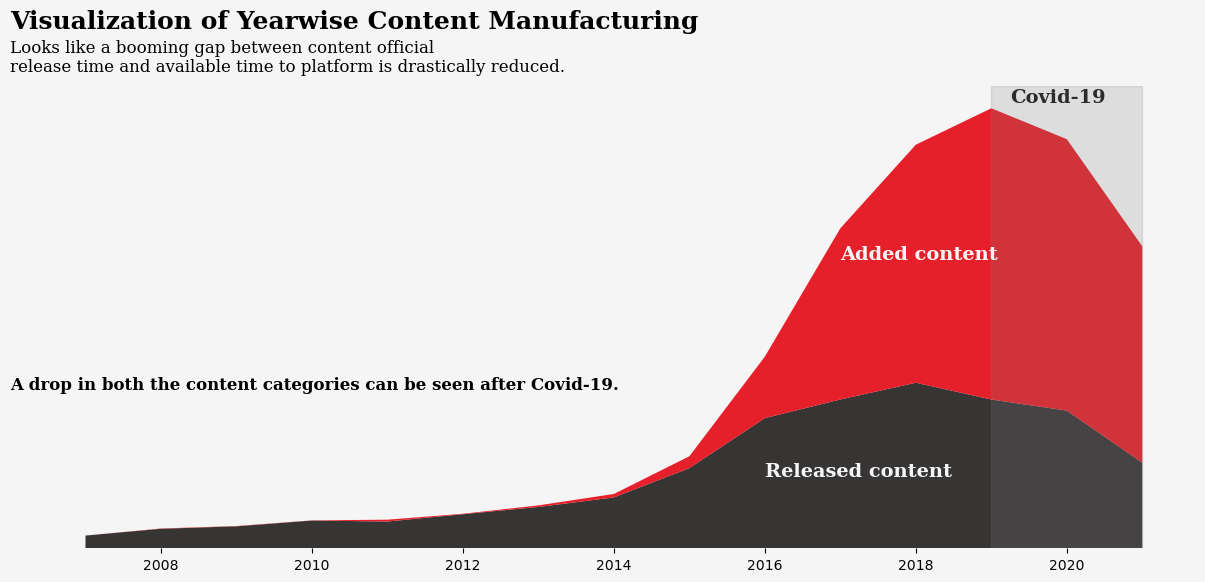

In [32]:
fig, ax = plt.subplots(figsize = (15,6))
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')
labels = [ 'Released content', 'Added content ']
ax.stackplot(year_df.year[0:15], year_df.release_year[0:15],year_df.added_year[0:15],labels =labels, 
              colors = ['#221f1f','#e50914'], baseline = 'zero', alpha = 0.9 )
ax.axvspan(2019,2021, color = 'grey',alpha = 0.2)
ax.text(2019.25, 3090, 'Covid-19', {'font':'serif', 'fontsize': '14', 'color': 'black', 'weight':'bold'},alpha = 0.8)
ax.text(2017, 2000, '{}'.format(labels[1]), {'font':'serif', 'fontsize':'14', 'color':'#f6f5f5', 'weight':'bold'})
ax.text(2016, 500, '{}'.format(labels[0]),{'font':'serif', 'fontsize':'14', 'color':'#f6f5f5','weight':'bold'}) 
ax.text(2006, 3600, 'Visualization of Yearwise Content Manufacturing', 
                      {'font':'serif', 'fontsize':'18', 'weight': 'bold','color': 'black'})
ax.text(2006, 3300, 'Looks like a booming gap between content official \nrelease time and available time to platform is drastically reduced. ',
                      {'font':'serif', 'fontsize':'12','color': 'black'})
ax.text(2006, 1100, "A drop in both the content categories can be seen after Covid-19.", {'font':'serif', 'fontsize':'12','color': 'black','weight':'bold'})
plt.box(on = None)
ax.axes.get_yaxis().set_visible(False)
fig.show()

In [33]:
TV = df[df['type'] == 'TV Show'].release_year.value_counts()
Movie = df[df['type'] == 'Movie'].release_year.value_counts()

# creating a dataframe

Tv_df = pd.DataFrame({'year': TV.index, 'Tv_count': TV.values})
Movie_df = pd.DataFrame({'year': Movie.index, 'Movie_count': Movie.values})

rel_data = pd.merge(Tv_df, Movie_df, how = 'right', on = 'year')
rel_data.fillna('0', inplace = True)
rel_data['Tv_count'] = rel_data.Tv_count.astype('int64')
rel_data = rel_data.sort_values('year', ascending = False).reset_index(drop = True)


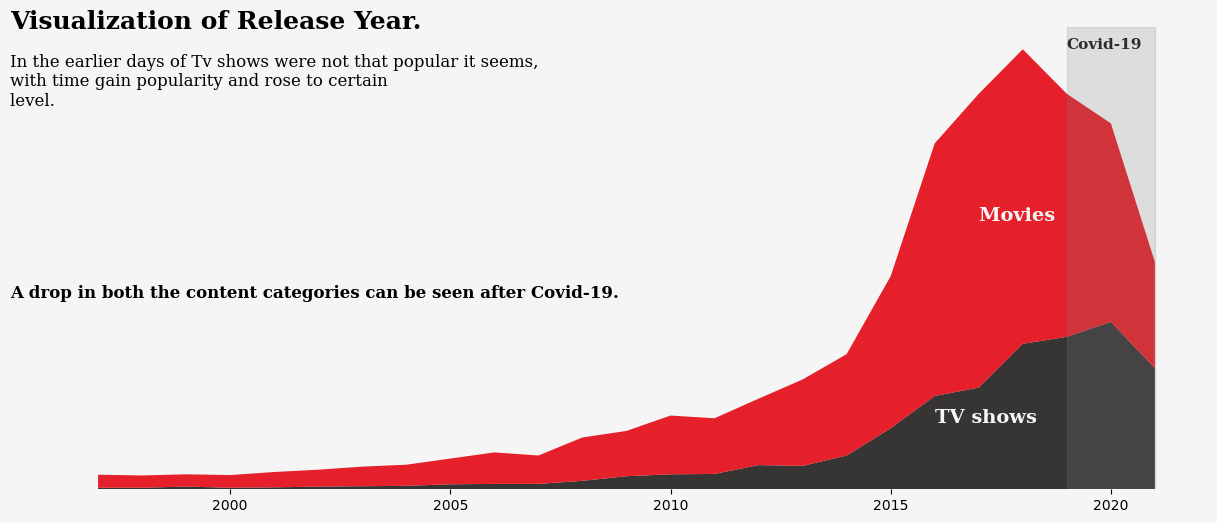

In [34]:
fig, ax = plt.subplots(figsize = (15,6))
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

labels = [ 'TV shows', 'Movies ']
ax.stackplot(rel_data.year[0:25], rel_data.Tv_count[0:25],rel_data.Movie_count[0:25],labels =labels, 
              colors = ['#221f1f','#e50914'], baseline = 'zero', alpha = 0.9 )
ax.axvspan(2019,2021, color = 'grey',alpha = 0.2)
ax.text(2019, 1147, 'Covid-19', {'font':'serif', 'fontsize': '11', 'color': 'black', 'weight':'bold'},alpha = 0.8)
ax.text(2017, 700, '{}'.format(labels[1]), {'font':'serif', 'fontsize':'14', 'color':'#f6f5f5', 'weight':'bold'})
ax.text(2016, 175, '{}'.format(labels[0]),{'font':'serif', 'fontsize':'14', 'color':'#f6f5f5','weight':'bold'}) 
ax.text(1995,1200, 'Visualization of Release Year.',
                      {'font':'serif', 'fontsize':'18', 'weight': 'bold','color': 'black'})
ax.text(1995,1000, 'In the earlier days of Tv shows were not that popular it seems, \nwith time gain popularity and rose to certain \nlevel. ',
                      {'font':'serif', 'fontsize':'12','color': 'black'})
ax.text(1995, 500, "A drop in both the content categories can be seen after Covid-19.", {'font':'serif', 'fontsize':'12','color': 'black','weight':'bold'})
plt.box(on = None)
ax.axes.get_yaxis().set_visible(False)
fig.show()

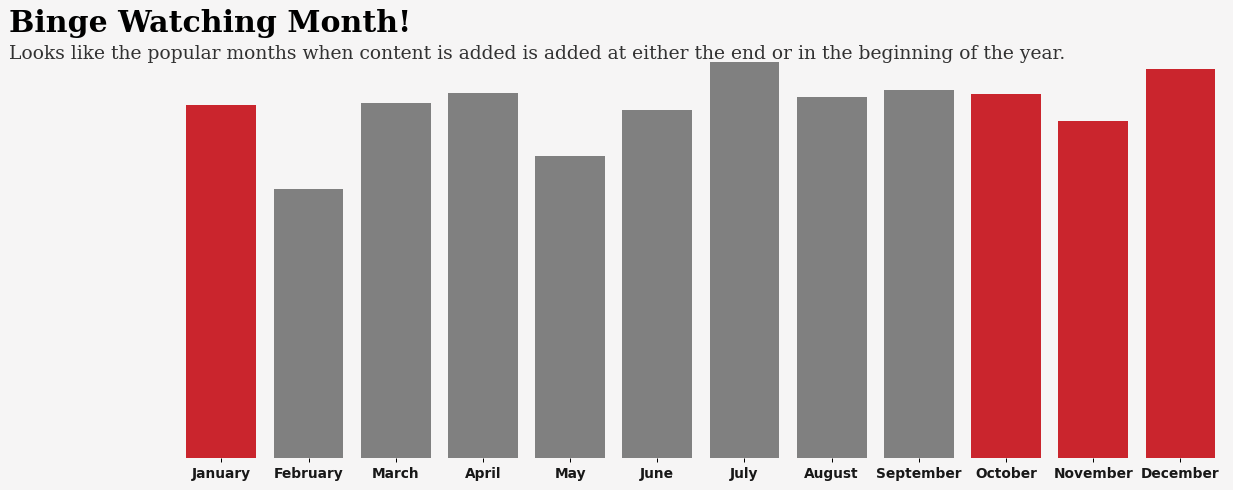

In [35]:
fig, ax = plt.subplots(figsize=(15,6),dpi=90)
ax.set_facecolor('#f6f5f5')
fig.patch.set_facecolor('#f6f5f5')
colors = [ '#e50914', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', '#e50914','#e50914','#e50914']
orders = ['January','February','March','April','May','June','July','August','September','October','November','December']
sns.countplot(x=df['added_month'],
              order=orders, 
              palette=colors,ax=ax)
fig.text(0, 0.90,'Binge Watching Month!', 
         {'font':'serif', 'fontsize': '24', 'color': 'black', 'weight':'bold'},alpha = 1)
fig.text(0,0.85,'Looks like the popular months when content is added is added at either the end or in the beginning of the year.',
         {'font':'serif', 'fontsize': '15', 'color': 'black'},alpha = 0.8)
ax.set_xlabel('')
ax.set_xticklabels(orders,fontweight='bold', alpha=0.9,fontsize=11)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.show()

<h2 style = "font-size:50px; font-family:Garamond ; font-weight : normal; background-color: #f6f6f6 ; color : 'black'; text-align: center; border-radius: 100px 100px;"> 7. Netflix Content Country Analysis</h2>

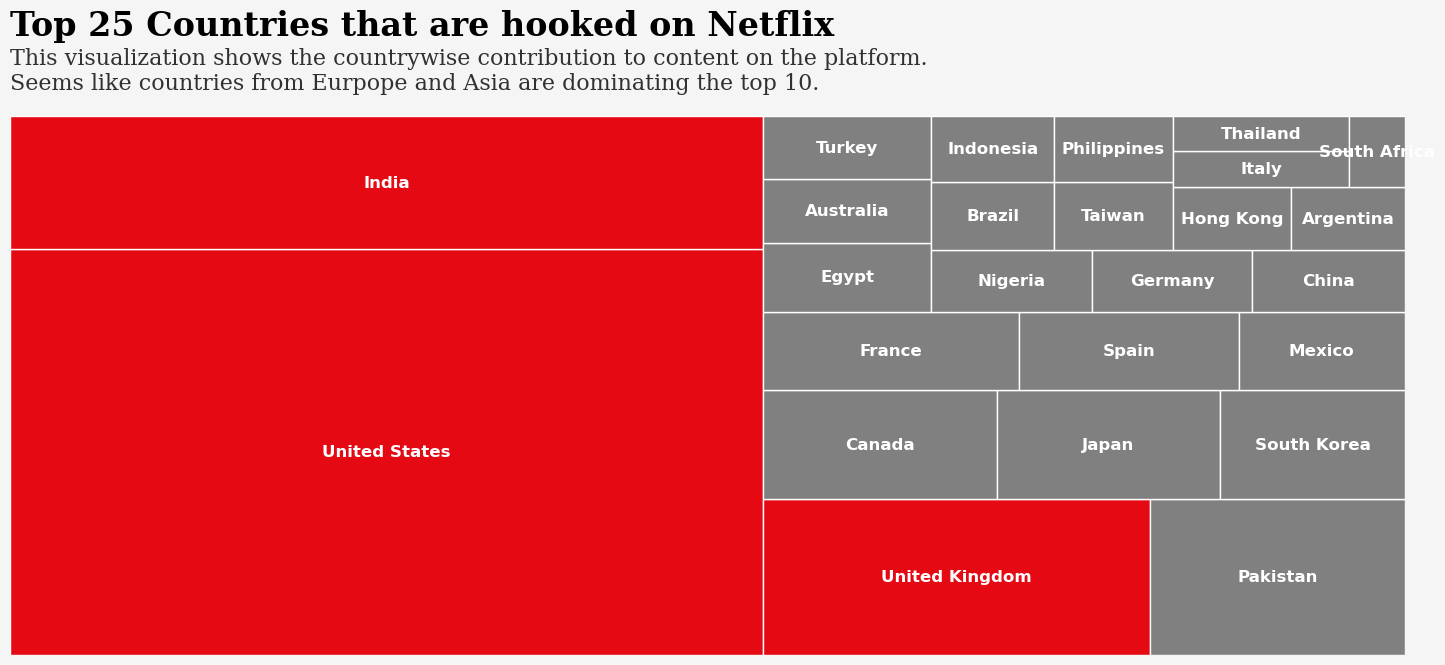

In [36]:
country_df = round(df[df['country'] != 'Not Given'].country.value_counts())[:25].reset_index()
country_df.columns = ['country','percentage']
colors = ['#e50914' if i < 3 else 'grey' for i in range(len(country_df))]
fig, ax = plt.subplots(figsize=(18,7))
ax.set_axis_off()
ax.set_facecolor('#f6f5f5')
fig.patch.set_facecolor('#f6f5f5')
# labels =
squarify.plot(
   sizes=country_df["percentage"],  
   label= country_df.country,
   color= colors,
   text_kwargs={'color':'white','fontweight':'bold','fontsize':'12'},
    bar_kwargs={'edgecolor': 'white', 'linewidth': 1},
   ax=ax
)
ax.text(0,115,'Top 25 Countries that are hooked on Netflix',{'font':'serif', 'size':24, 'color':'black', 'weight':'bold'}, alpha = 1)
ax.text(0,105, 'This visualization shows the countrywise contribution to content on the platform. \nSeems like countries from Eurpope and Asia are dominating the top 10.',
       {'font':'serif', 'size':16, 'color':'black'}, alpha = 0.8)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

for loc in ['left','right','top', 'bottom']:
    ax.spines[loc].set_visible(False)
plt.show()

In [37]:
tv_content = df[df['type'] == 'TV Show']
movie_content = df[df['type'] == 'Movie']

In [38]:
tv_content.shape,movie_content.shape

((2664, 14), (6126, 14))

In [39]:
tv_country = tv_content.country.value_counts().reset_index()[:5]
tv_country.columns = ['Country','Counts']

movie_country = (movie_content[movie_content['country'] != 'Not Given'].country.value_counts().reset_index()[:5])
movie_country.columns = ['Country', 'Counts']

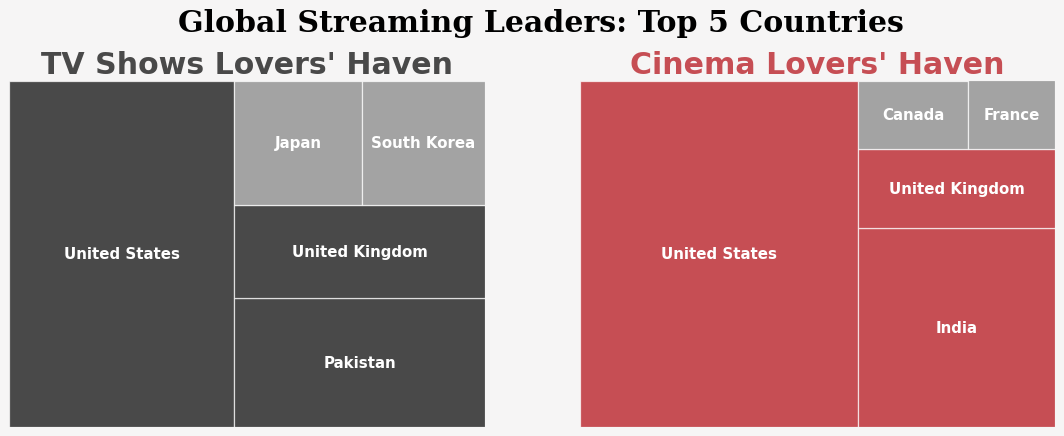

In [40]:
tv_data = tv_country['Counts'].tolist()
movie_data = movie_country['Counts'].tolist()
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=90)
fig.patch.set_facecolor('#f6f5f5')
tv_colors = ['black' if i < 3 else 'grey' for i in range(len(tv_data))]
squarify.plot(sizes=tv_data, label=tv_country.Country, color=tv_colors, alpha=0.7, ax=ax[0],
   text_kwargs={'color':'white','fontweight':'bold','fontsize':'12'},
    bar_kwargs={'edgecolor': 'white', 'linewidth': 1})
ax[0].set_title("TV Shows Lovers' Haven", fontdict={'fontsize': 24, 'weight': 'bold'}, loc='center', color='black', alpha=0.7)
ax[0].axis('off')
movie_colors = ['#b20710' if i < 3 else 'grey' for i in range(len(movie_data))]
squarify.plot(sizes=movie_data, label=movie_country.Country,color=movie_colors, alpha=0.7, ax=ax[1],
   text_kwargs={'color':'white','fontweight':'bold','fontsize':'12'},
    bar_kwargs={'edgecolor': 'white', 'linewidth': 1})
ax[1].set_title("Cinema Lovers' Haven", fontdict={'fontsize': 24, 'weight': 'bold'}, loc='center', color='#b20710', alpha=0.7)
ax[1].axis('off')
fig.text(0.25, 0.99, "Global Streaming Leaders: Top 5 Countries",
         {'font': 'serif', 'size': 24, 'color': 'black', 'weight': 'bold'}, alpha=1)
fig.show()

<h2 style = "font-size:50px; font-family:Garamond ; font-weight : normal; background-color: #f6f6f6 ; color : 'black'; text-align: center; border-radius: 100px 100px;"> 7. International Content vs. Domestic Content</h2>

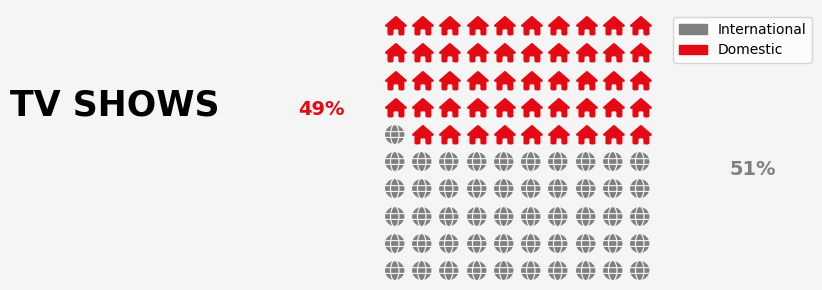

In [41]:
tv_data = round(tv_content['content_origin'].value_counts(normalize=True) * 100, 2)
tv_dict = dict(tv_data)
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    figsize=(18,3),
    columns=10,  
    colors= ['grey','#e50914'],
    values=tv_dict,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1)},
    facecolor = '#f6f5f5',
    icons = ['globe','house'],
    vertical=True
)
fig.patch.set_facecolor('#f6f5f5')
# fig.text(-0.25,1.035,'Content Origin Distribution for TV Shows.', {'size':18, 'weight':'bold'}, alpha = 1)
# fig.text(-0.3,0.90,"With 750k male viewers, it seems like \nthe majority of the audience is male.",{'size':10, 'weight':'normal'}, alpha = 0.9)
fig.text(-0.04,0.60, "49%",{'size':14, 'weight':'bold','color':'#e50914'})
fig.text(-0.2,0.60, "TV SHOWS",{'size':25, 'weight':'bold','color':'black'})
fig.text(0.2,0.40, "51%",{'size':14, 'weight':'bold','color':'grey'})
fig.show()

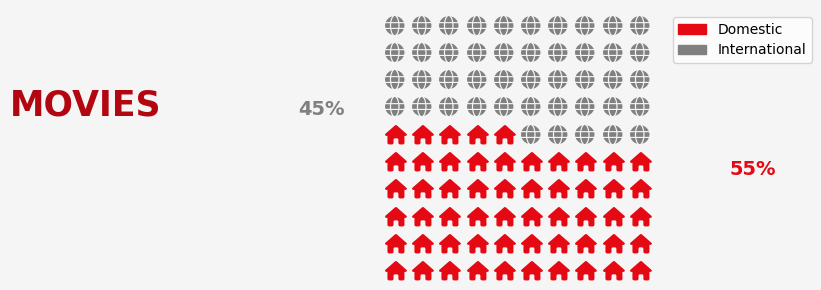

In [42]:
movie_data = round(movie_content['content_origin'].value_counts(normalize=True) * 100, 2)
movie_dict = dict(movie_data)
fig = plt.figure(
    FigureClass=Waffle,
    rows=10,
    figsize=(18,3),
    columns=10,  
    colors= ['#e50914','grey'],
    values=movie_dict,
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1)},
    facecolor = '#f6f5f5',
    icons = ['house','globe'],
    vertical=True
)
fig.patch.set_facecolor('#f6f5f5')
# fig.text(-0.25,1.035,'Content Origin Distribution for TV Shows.', {'size':18, 'weight':'bold'}, alpha = 1)
# fig.text(-0.3,0.90,"With 750k male viewers, it seems like \nthe majority of the audience is male.",{'size':10, 'weight':'normal'}, alpha = 0.9)
fig.text(-0.04,0.60, "45%",{'size':14, 'weight':'bold','color':'grey'})
fig.text(-0.2,0.60, "MOVIES",{'size':25, 'weight':'bold','color':'#b20710'})
fig.text(0.2,0.40, "55%",{'size':14, 'weight':'bold','color':'#e50914'})
fig.show()

<h2 style = "font-size:50px; font-family:Garamond ; font-weight : normal; background-color: #f6f6f6 ; color : 'black'; text-align: center; border-radius: 100px 100px;"> 8. Netflix Content Genre Analysis</h2>

In [43]:
def genere(what):
    if what == 'all':
        genere = df.listed_in.explode().value_counts()
    else:
        genere = df[df['type'] == what].listed_in.explode().value_counts()
    
    gener = {}
    
    for idx, val in genere.items():
        idx = idx.strip()
        if idx in gener:
            gener[idx] += val
        else:
            gener[idx] = val

    theme, count = [], []
    for idx, val in gener.items():
        theme.append(idx)
        count.append(val)
    
    list_temp = (
        pd.DataFrame({'genre': theme, 'count': count})
        .sort_values('count', ascending=True)
        .reset_index(drop=True)
    )
    
    return list_temp

tv_genre = genere('TV Show')
mov_genre = genere('Movie')


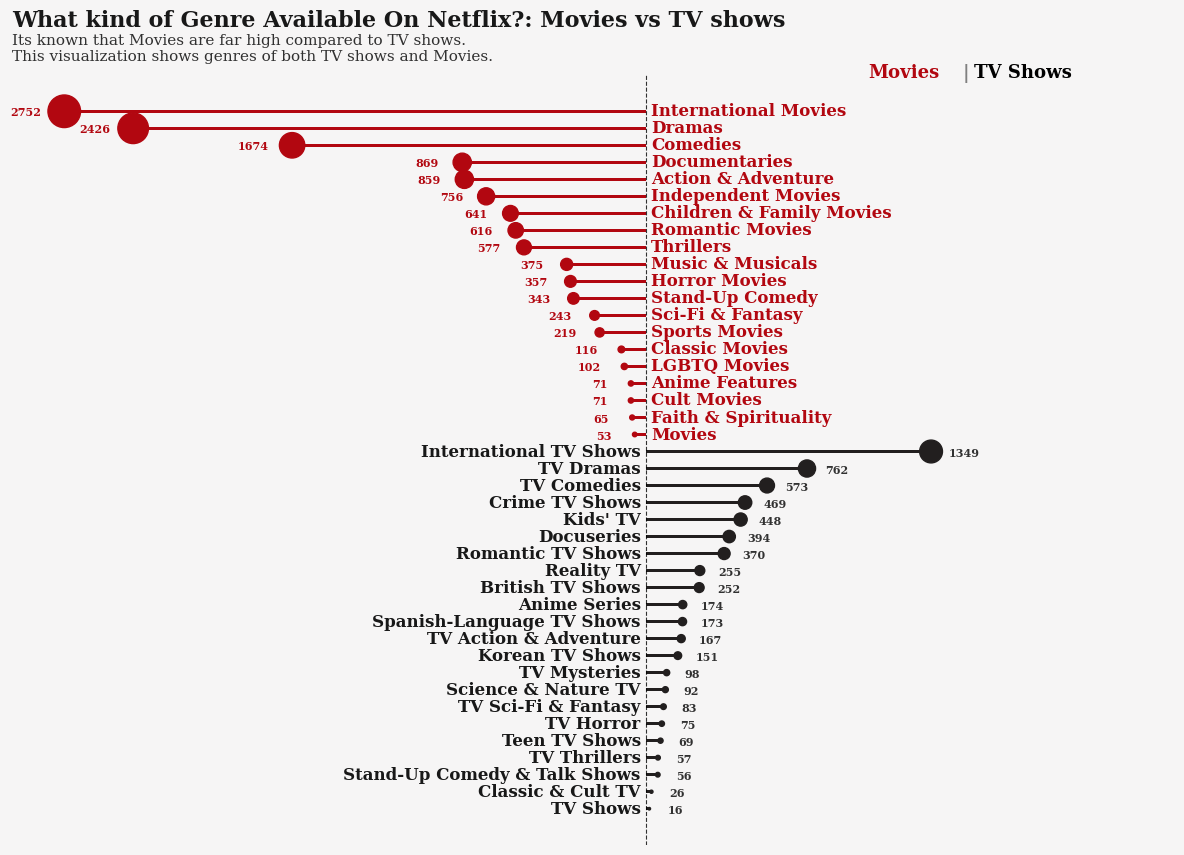

In [44]:
fig, ax  = plt.subplots(figsize = (15,10))

colors = ['#b20710']
fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

ax.barh( y = tv_genre['genre'], width = tv_genre['count'], height = 0.15, color = ['#221f1f'])
ax.scatter( y = tv_genre['genre'], x =  tv_genre['count'], s = tv_genre['count'] * 0.2, c = '#221f1f')

ax.barh( y = mov_genre['genre'], width = - mov_genre['count'], height = 0.15, color = ['#b20710'])
ax.scatter( y = mov_genre['genre'], x =  -mov_genre['count'], s=mov_genre['count']*0.2 , c = '#b20710')

ax.axvline(x = 0, ymin = 0, ymax = 1, **{'linewidth':0.8, 'linestyle': '--', 'color' : 'black'}, alpha = 0.8)

tv_index = tv_genre['genre']
mov_index = mov_genre['genre']

tv_count = tv_genre['count']
mov_count = mov_genre['count']

for y_loc in range(0,22):
        ax.text(-25, y_loc - 0.25 , tv_index[y_loc],horizontalalignment= 'right',**{'font':'serif', 'size':12, 'weight':'bold', 'color':'black'}, alpha = 0.9)
        ax.text(tv_count[y_loc] + 85, y_loc - 0.25, tv_count[y_loc],horizontalalignment= 'left',**{'font':'serif', 'size':8, 'weight':'bold', 'color':'black'}, alpha = 0.8)
        
        
for y_loc in range(0,20):
        ax.text(25, 22+y_loc - 0.25, mov_index[y_loc],horizontalalignment = 'left',**{'font':'serif', 'size':12, 'weight':'bold', 'color':'#b20710'}, alpha =1)
        ax.text(-mov_count[y_loc] - 110,  22 + y_loc - 0.25 , mov_count[y_loc],horizontalalignment= 'right',**{'font':'serif', 'size':8, 'weight':'bold', 'color':'#b20710'}, alpha =1)
    
for loc in ['left', 'right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.set_xlim([-3000,2500])

ax.text(-3000, 46, 'What kind of Genre Available On Netflix?: Movies vs TV shows',{'font':'serif', 'size':16, 'weight':'bold', 'color':'black'}, alpha = 0.9)
ax.text(-3000, 44, 'Its known that Movies are far high compared to TV shows. \nThis visualization shows genres of both TV shows and Movies.',{'font':'serif', 'size':11, 'color':'black'}, alpha = 0.8)

ax.text(1050, 43, 'Movies',{'font':'serif', 'size':13, 'color':'#b20710', 'weight':'bold'}, alpha = 1)
ax.text(1500, 43, '|',{'font':'serif', 'size':13, 'color':'grey','weight':'bold'}, alpha = 1)
ax.text(1550, 43, 'TV Shows',{'font':'serif', 'size':13, 'color':'black', 'weight':'bold'}, alpha = 1)

fig.show()


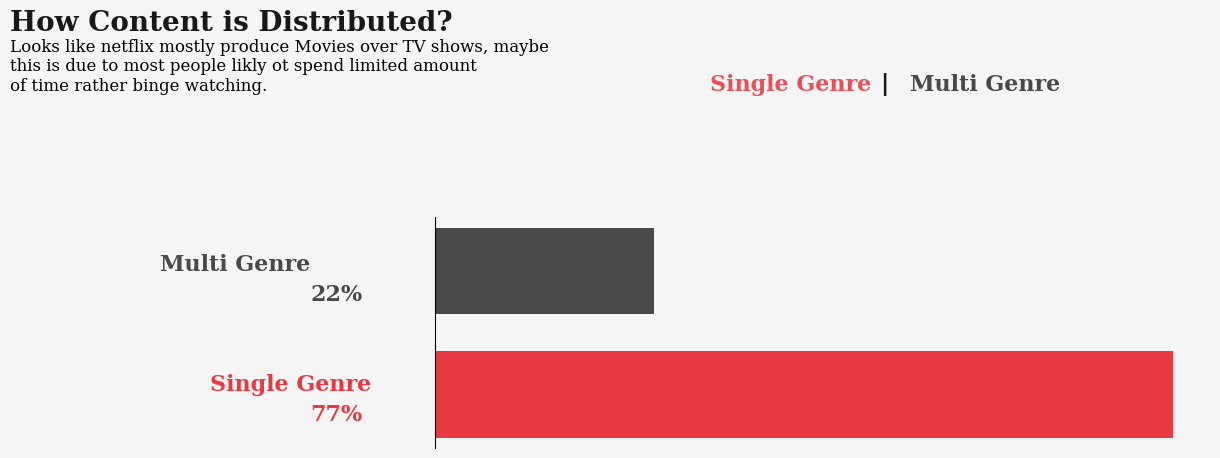

In [46]:
x = df['genre_type'].value_counts()

# plot
fig, ax = plt.subplots(figsize = (10,3))
ax.barh([1], x.values[1], height = 0.7, color = 'black', alpha = 0.7)
fig.text(-0.15,0.7, 'Multi Genre', {'font': 'Serif','weight':'bold','size': '16','style':'normal', 'color':'black'}, alpha = 0.7)
fig.text(0,0.6, '22%',{'font':'Serif', 'weight':'bold','size':'16','color':'black'}, alpha = 0.7)


ax.barh([0], x.values[0], height = 0.7, color = '#e50914', alpha = 0.8)
fig.text(-0.1,0.3, 'Single Genre',{'font': 'Serif','weight':'bold','size': '16','style':'normal', 'color':'#e50914'}, alpha = 0.8)
fig.text(0,0.2, '77%',{'font':'Serif','weight':'bold' ,'size':'16','color':'#e50914'}, alpha = 0.8)

['#e50914','grey']

fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

fig.text(-0.3,1.5, 'How Content is Distributed?' ,{'font': 'Serif', 'size': '20','weight':'bold', 'color':'black'}, alpha = 0.9)
fig.text(0.40,1.3, 'Single Genre ', {'font': 'Serif','weight':'bold','size': '16', 'color':'#e50914'}, alpha = 0.7)
fig.text(0.57, 1.3,'|', {'color':'black' , 'size':'16', 'weight': 'bold'}, alpha = 0.9)
fig.text(0.6, 1.3,'Multi Genre', {'font': 'Serif','weight':'bold', 'size': '16','color':'black'}, alpha = 0.7)
fig.text(-0.3,1.3, 'Looks like netflix mostly produce Movies over TV shows, maybe \nthis is due to most people likly ot spend limited amount \nof time rather binge watching.', 
        {'font':'Serif', 'size':'12','color': 'black'})

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

<h2 style = "font-size:50px; font-family:Garamond ; font-weight : normal; background-color: #f6f6f6 ; color : 'black'; text-align: center; border-radius: 100px 100px;"> 9. Binge-Worthy Buzzwords:
    Netflix Titles Summed Up in a Cloud!</h2>

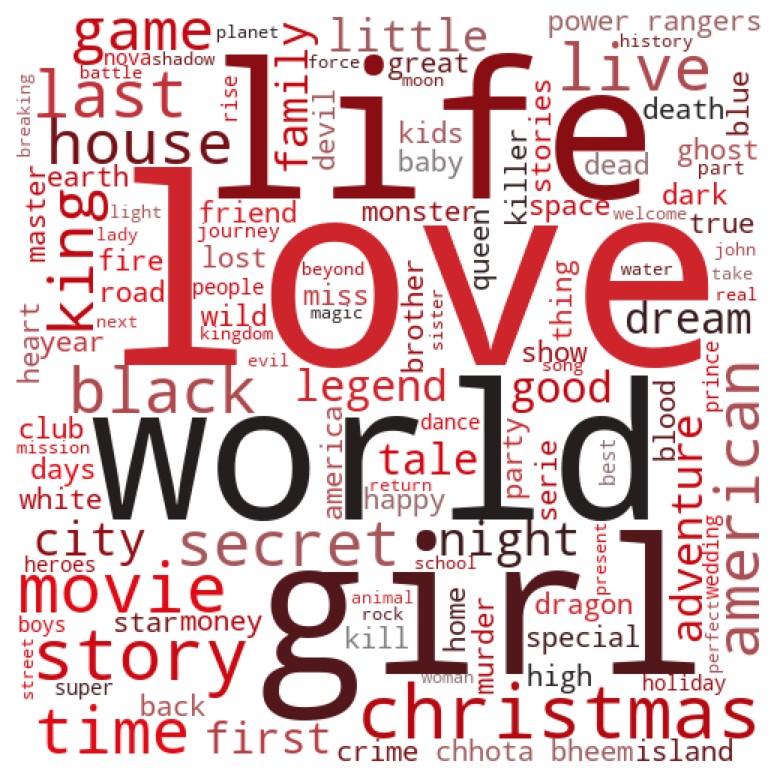

In [47]:
import matplotlib
comment_words = '' 
stopwords = set(STOPWORDS) 

for word in df.title:
    words = word.split(',')
    for i in words:
        token = i.lower()
        comment_words += "".join(token) + ' '
colors = ['#221f1f', '#b20710', '#e50914','grey']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors = colors)
wordcloud = WordCloud(width = 500, height = 500, 
                background_color ='white', min_word_length = 4,
                stopwords = stopwords, colormap = colormap,
                min_font_size = 10).generate(comment_words) 
plt.rcParams['figure.dpi'] = 150
plt.figure(figsize = (10,5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 
